In [8]:
from Lab_Analyses.Spine_Analysis_v2 import spine_utilities as s_utils
from Lab_Analyses.Utilities.save_load_pickle import load_pickle
from Lab_Analyses.Spine_Analysis_v2.spine_activity_dataclass import Grouped_Spine_Activity_Data
import numpy as np
import os

In [53]:
# load all the current apical spine data
id_1 = "JW082"
id_2 = "JW083" 
id_3 = "JW090"
id_4 = "JW092"
#id_5 = "JW126" # Not using
id_6 = "JW129" 
id_7 = "JW130" # Should I use? Nathan suspects layer 5?
id_8 = "JW153"
id_9 = "JW150"
id_10 = "JW168"
id_11 = "JW202"
id_13 = "JW241" # Not using
id_14 = "JW242" # Not using

mouse_list = [id_1, id_2, id_3, id_4, id_6, id_7, id_8, id_9, id_10, id_11]

early_activity_data = s_utils.batch_load_individual_analyzed_datasets(
    type="Activity",
    session="Early",
    norm=True,
    activity_type="dFoF",
    extended=None,
    mice_list=mouse_list,
    fov_type="apical",
    period=None,
    partner=None,
)
early_activity_data = Grouped_Spine_Activity_Data(early_activity_data)

control_spine_volumes = early_activity_data.spine_volumes

In [107]:
## Load the kir data
kir_ids = ["JW255", "JW256", "JW255"]

kir_spine_volumes = []

initial_path = r"C:\Users\Jake\Desktop\Analyzed_data\individual"
for mouse in kir_ids:
    mouse_path = os.path.join(initial_path, mouse)
    imaging_path = os.path.join(mouse_path, "imaging")
    FOVs = next(os.walk(imaging_path))[1]
    FOVs = [x for x in FOVs if "FOV" in x]
    for FOV in FOVs:
        FOV_path = os.path.join(imaging_path, FOV)
        fnames = next(os.walk(FOV_path))[2]
        fnames = [x for x in fnames if "imaging_data" in x]
        GluSnFr_fname = os.path.join(
                FOV_path,
                [
                    x
                    for x in fnames
                    if "GreenCh" in x and "structural" not in x
                ][0],
            )
        GluSnFr_data = load_pickle([GluSnFr_fname])[0]
        spine_volume = GluSnFr_data.corrected_spine_volume
        pix_to_um = 8 / 2
        um_spine_volume = (np.sqrt(spine_volume) / pix_to_um) ** 2
        kir_spine_volumes.append(um_spine_volume)
        
kir_spine_volumes = np.concatenate(kir_spine_volumes)

In [108]:
# Plot and stats
from Lab_Analyses.Plotting.plot_histogram import plot_histogram
from Lab_Analyses.Plotting.plot_box_plot import plot_box_plot
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style("ticks")

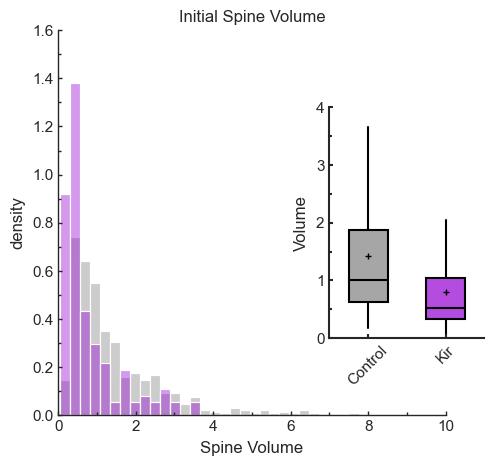

In [115]:
fig, axes = plt.subplot_mosaic("""A""", figsize=(5,5))
COLORS = ["grey", "darkviolet"]
plot_histogram(
        data=list((
            control_spine_volumes, kir_spine_volumes
        )),
        bins=30,
        stat="density",
        avlines=None,
        title="Initial Spine Volume",
        xtitle="Spine Volume",
        xlim=(0, None),
        figsize=(5,5),
        color=COLORS,
        alpha=0.4,
        minor_ticks="both",
        tick_len=3,
        ax=axes["A"],
        save=False,
        save_path=None,
    )

## Inset box plot
ax_D_inset = axes["A"].inset_axes([0.7, 0.2, 0.4, 0.6])
sns.despine(ax=ax_D_inset)
plot_box_plot(
        data_dict={"Control": control_spine_volumes, "Kir": kir_spine_volumes},
        figsize=(5,5),
        title=None,
        xtitle=None,
        ytitle="Volume",
        ylim=(0, None),
        b_colors=["grey", COLORS[1]],
        b_edgecolors="black",
        b_err_colors="black",
        m_color="black",
        m_width=1.5,
        b_width=0.5,
        b_linewidth=1.5,
        b_alpha=0.7,
        b_err_alpha=1,
        whisker_lim=None,
        whisk_width=1.5,
        outliers=False,
        showmeans=True,
        axis_width= 1.5,
        minor_ticks="y",
        tick_len=3,
        ax=ax_D_inset,
        save=False,
        save_path=None,
    )
fig.savefig(r"C:\Users\Jake\Desktop\Figures\grouped_data\Kir_Population_Data\Spine_Volume_Fig" + ".pdf")

In [110]:
from scipy import stats
t, p = stats.mannwhitneyu(
    control_spine_volumes[~np.isnan(control_spine_volumes)],
    kir_spine_volumes[~np.isnan(kir_spine_volumes)]
)
print(f"Control n = {len(control_spine_volumes)}  Kir n = {len(kir_spine_volumes)}")
print(f"t = {t}  p = {p}")

Control n = 670  Kir n = 144
t = 52891.0  p = 4.411053044281054e-16


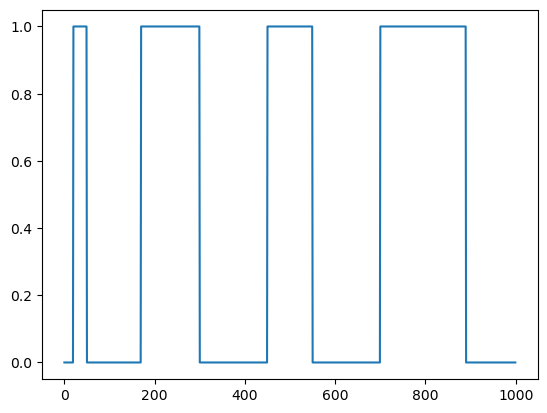

In [6]:
import numpy as np
import matplotlib.pyplot as plt

a = np.zeros(1000)
ones = [(20,50),(170, 300), (450,550), (700, 890)]
for i in ones:
    a[i[0]:i[1]] = 1


plt.figure()
plt.plot(a)

In [9]:
b = np.zeros(a.shape[0]) * np.nan
dend_activity = np.hstack((a.reshape(-1,1), b.reshape(-1,1), np.flip(a.reshape(-1,1))))
dend_activity.shape

(1000, 3)

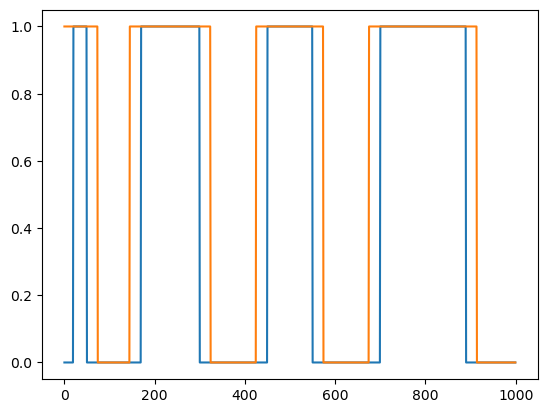

In [16]:


expansion = 50
exp_constant = np.ones(expansion, dtype=int)
npad = len(exp_constant) - 1
extended_activity = np.zeros(dend_activity.shape)

for i in range(dend_activity.shape[1]):
    if not np.nansum(dend_activity[:, i]):
        extended_activity[:, i] = dend_activity[:, i]
        continue
    d_pad = np.pad(
        dend_activity[:, i], (npad // 2, npad-npad//2), mode="constant",
    )
    d_extend = np.convolve(d_pad, exp_constant, "valid").astype(bool).astype(int)
    extended_activity[:, i] = d_extend
    
    
plt.figure()
plt.plot(dend_activity[:, 0])
plt.plot(extended_activity[:, 0])